# Negative L1 norm prior experiment

This code attempts to learn the 64D prior
$J(x) = -||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i) = -t/2 - |x|$

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/NegL1_prior_64D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Negative L1 Norm J(x) = -||x||_1
    # S(x, t) = -t/2 - |x| (per dimension)
    # For n dimensions: S(x, t) = - (n*t)/2 - ||x||_1
    
    dim = y.shape[1]
    l1_norm = np.sum(np.abs(y), axis=1)
    return -(t) / 2.0 - l1_norm


def prior_true(y):
    # J(x) = -||x||_1
    return -np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Convex functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Convex functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions ($x_1$,0)',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}",fontsize=16)
        plt.xlabel('$x_1$',fontsize=16)
        plt.ylabel('Prior functions ($0,x_2$,0)',fontsize=16)
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 64

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 90713.90625
iteration 0 loss 72874.359375


iteration 5000 loss 118.25299835205078


iteration 10000 loss 48.917659759521484


iteration 15000 loss 3.09696364402771


iteration 20000 loss 1.2123427391052246


iteration 25000 loss 0.7043260335922241


iteration 30000 loss 0.46489763259887695


iteration 35000 loss 0.3310442268848419


iteration 40000 loss 0.2638126313686371


iteration 45000 loss 0.2077738642692566


iteration 50000 loss 0.17232868075370789


iteration 55000 loss 0.14209383726119995


iteration 60000 loss 0.11858519911766052


iteration 65000 loss 0.10332498699426651


iteration 70000 loss 0.08949945122003555


iteration 75000 loss 0.07718810439109802


iteration 80000 loss 0.06852157413959503


iteration 85000 loss 0.06242331489920616


iteration 90000 loss 0.054917655885219574


iteration 95000 loss 0.04919116571545601


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.04554229602217674


iteration 105000 loss 0.042806658893823624


iteration 110000 loss 0.03846334293484688


iteration 115000 loss 0.0352197140455246


iteration 120000 loss 0.03180049732327461


iteration 125000 loss 0.02954944595694542


iteration 130000 loss 0.02712610363960266


iteration 135000 loss 0.024952981621026993


iteration 140000 loss 0.022916922345757484


iteration 145000 loss 0.021280433982610703


iteration 150000 loss 0.019578976556658745


iteration 155000 loss 0.018300041556358337


iteration 160000 loss 0.016933541744947433


iteration 165000 loss 0.01590930111706257


iteration 170000 loss 0.014789498411118984


iteration 175000 loss 0.013936112634837627


iteration 180000 loss 0.012982520274817944


iteration 185000 loss 0.012268416583538055


iteration 190000 loss 0.011489943601191044


iteration 195000 loss 0.01085345447063446


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.010183757171034813


iteration 205000 loss 0.009736217558383942


iteration 210000 loss 0.009237495250999928


iteration 215000 loss 0.008629947900772095


iteration 220000 loss 0.008081117644906044


iteration 225000 loss 0.007665372919291258


iteration 230000 loss 0.007205558475106955


iteration 235000 loss 0.006850167643278837


iteration 240000 loss 0.006459172815084457


iteration 245000 loss 0.006164448335766792


iteration 250000 loss 0.005804357584565878


iteration 255000 loss 0.005546221509575844


iteration 260000 loss 0.005235051736235619


iteration 265000 loss 0.005012709181755781


iteration 270000 loss 0.004767837934195995


iteration 275000 loss 0.004541905131191015


iteration 280000 loss 0.004343753214925528


iteration 285000 loss 0.0041201370768249035


iteration 290000 loss 0.003953929059207439


iteration 295000 loss 0.0037462743930518627


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.0035914145410060883


iteration 305000 loss 0.0035235160030424595


iteration 310000 loss 0.0032666237093508244


iteration 315000 loss 0.003020070493221283


iteration 320000 loss 0.0027932608500123024


iteration 325000 loss 0.002583819907158613


iteration 330000 loss 0.002391349757090211


iteration 335000 loss 0.0022137376945465803


iteration 340000 loss 0.002052814234048128


iteration 345000 loss 0.001906501711346209


iteration 350000 loss 0.0017705356003716588


iteration 355000 loss 0.0016435317229479551


iteration 360000 loss 0.0015346829313784838


iteration 365000 loss 0.0014327469980344176


iteration 370000 loss 0.0013431222178041935


iteration 375000 loss 0.0012629438424482942


iteration 380000 loss 0.0011894090566784143


iteration 385000 loss 0.0011206422932446003


iteration 390000 loss 0.0010570742888376117


iteration 395000 loss 0.000998625298961997


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.00094436394283548


iteration 405000 loss 0.0009320242679677904


iteration 410000 loss 0.000910494418349117


iteration 415000 loss 0.000890502124093473


iteration 420000 loss 0.0008713392307981849


iteration 425000 loss 0.0008528539328835905


iteration 430000 loss 0.000834898732136935


iteration 435000 loss 0.0008174352697096765


iteration 440000 loss 0.0008004069095477462


iteration 445000 loss 0.0007837793091312051


iteration 450000 loss 0.0007675088127143681


iteration 455000 loss 0.0007516002515330911


iteration 460000 loss 0.0007359969313256443


iteration 465000 loss 0.0007207417511381209


iteration 470000 loss 0.000705766782630235


iteration 475000 loss 0.0006910666124895215


iteration 480000 loss 0.00067666987888515


iteration 485000 loss 0.0006625318783335388


iteration 490000 loss 0.0006486580823548138


iteration 495000 loss 0.0006350419716909528


L2 loss -- Plot

loss -4.640018939971924


loss -172.11912536621094


loss -255.26858520507812


loss -323.35394287109375


loss -375.3845520019531


loss -409.11572265625


loss -425.92535400390625


loss -431.7689208984375


loss -433.0771789550781


loss -433.2523193359375


loss -433.2651672363281


loss -433.265625


loss -433.265625


loss -433.265625


loss -433.265625


loss -433.265625


loss -433.2655944824219


loss -433.265625


loss -433.265625


loss -433.265625


loss -433.265625


loss -433.265625


loss -433.265625


loss -433.265625


loss -433.265625


loss -433.265625


loss -433.265625


loss -433.265625


loss -433.265625


loss -433.265625


loss -433.265625


loss -433.265625


loss -433.265625


loss -433.265625


loss -433.265625


loss -433.265625


loss -433.265625


loss -433.265625


loss -433.265625


loss -433.265625


final mse:  2.0114936383208715e-09
max, min: 3.176338 -2.8973804
loss -4.640018939971924


loss -172.35067749023438


loss -255.42320251464844


loss -323.6613464355469


loss -375.93121337890625


loss -409.76483154296875


loss -426.4235534667969


loss -432.0572814941406


loss -433.25958251953125


loss -433.4085998535156


loss -433.41827392578125


loss -433.4185791015625


loss -433.4185791015625


loss -433.4186096191406


loss -433.4186096191406


loss -433.4185791015625


loss -433.4185791015625


loss -433.4186096191406


loss -433.4185791015625


loss -433.4186096191406


loss -433.4185791015625


loss -433.4185791015625


loss -433.4185791015625


loss -433.4185791015625


loss -433.4185791015625


loss -433.4185791015625


loss -433.4185791015625


loss -433.4185791015625


loss -433.4185791015625


loss -433.4185791015625


loss -433.4185791015625


loss -433.4185791015625


loss -433.4185791015625


loss -433.4185791015625


loss -433.4185791015625


loss -433.4185791015625


loss -433.4186096191406


loss -433.4185791015625


loss -433.4186096191406


loss -433.4185791015625


final mse:  1.2768955892639156e-09
max, min: 3.029308 -3.0735834


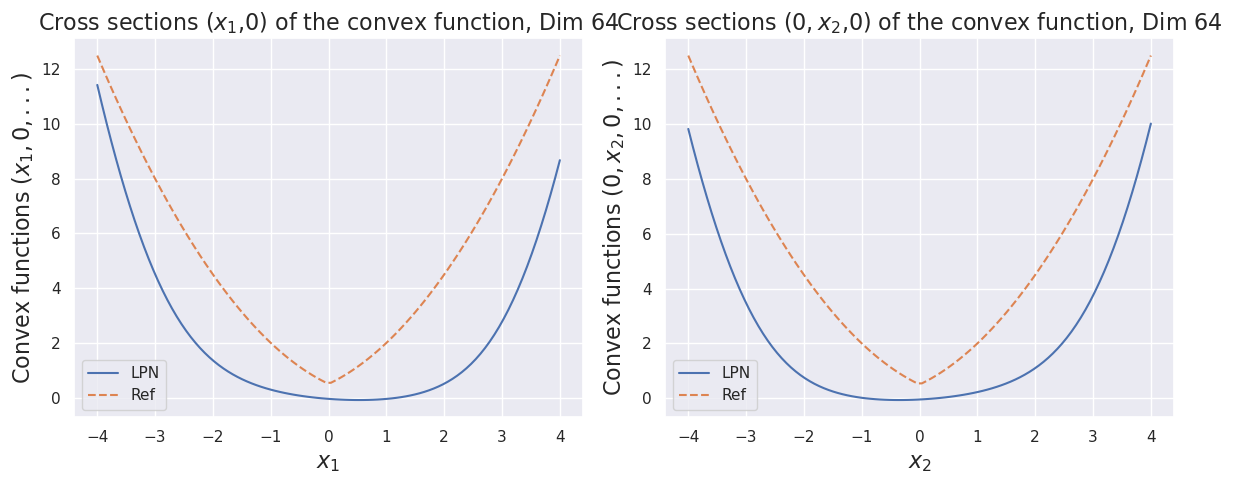

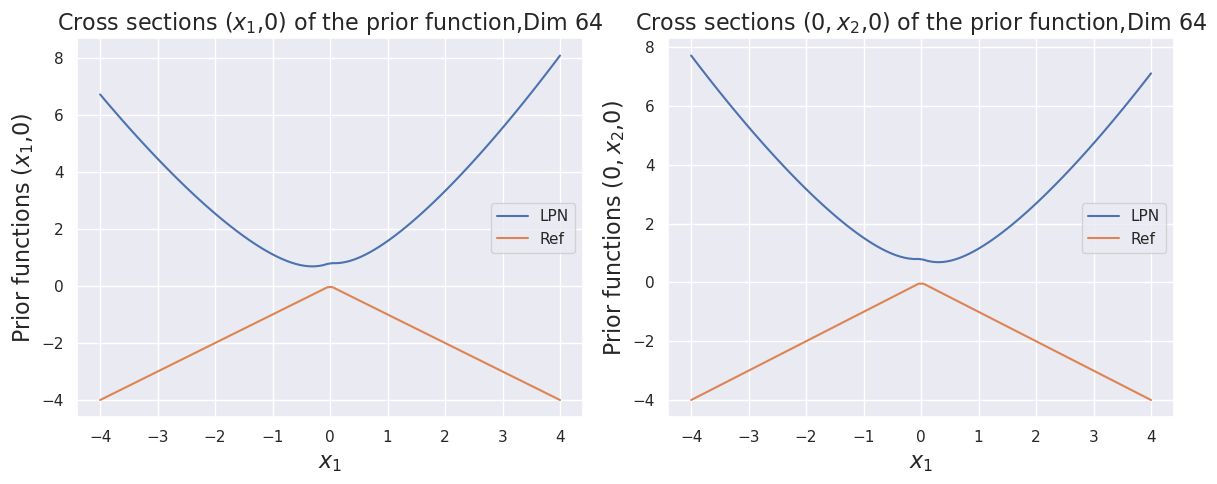

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 23417.76171875
iteration 0 loss 9118.732421875


iteration 5000 loss 8.34237003326416


iteration 10000 loss 2.465718984603882


iteration 15000 loss 1.180442214012146


iteration 20000 loss 0.7581490278244019


iteration 25000 loss 0.5321324467658997


iteration 30000 loss 0.38976702094078064


iteration 35000 loss 0.29845571517944336


iteration 40000 loss 0.23995453119277954


iteration 45000 loss 0.19639025628566742


iteration 50000 loss 0.1656935065984726


iteration 55000 loss 0.14156079292297363


iteration 60000 loss 0.1217823177576065


iteration 65000 loss 0.10675998032093048


iteration 70000 loss 0.09623885154724121


iteration 75000 loss 0.08609846979379654


iteration 80000 loss 0.07754692435264587


iteration 85000 loss 0.0704522654414177


iteration 90000 loss 0.0652879849076271


iteration 95000 loss 0.05992177501320839


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.0555696077644825


iteration 105000 loss 0.05424566566944122


iteration 110000 loss 0.050153326243162155


iteration 115000 loss 0.04669533669948578


iteration 120000 loss 0.043802887201309204


iteration 125000 loss 0.04090298339724541


iteration 130000 loss 0.03828555345535278


iteration 135000 loss 0.03603769466280937


iteration 140000 loss 0.034161437302827835


iteration 145000 loss 0.03242895379662514


iteration 150000 loss 0.030681593343615532


iteration 155000 loss 0.02928755432367325


iteration 160000 loss 0.027852319180965424


iteration 165000 loss 0.02646983228623867


iteration 170000 loss 0.02536962740123272


iteration 175000 loss 0.024194320663809776


iteration 180000 loss 0.023150118067860603


iteration 185000 loss 0.022130649536848068


iteration 190000 loss 0.021216148510575294


iteration 195000 loss 0.020304612815380096


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.01960982382297516


iteration 205000 loss 0.019294558092951775


iteration 210000 loss 0.01824876107275486


iteration 215000 loss 0.01729689911007881


iteration 220000 loss 0.016427746042609215


iteration 225000 loss 0.01563671976327896


iteration 230000 loss 0.014901912771165371


iteration 235000 loss 0.014249792322516441


iteration 240000 loss 0.013654468581080437


iteration 245000 loss 0.013091451488435268


iteration 250000 loss 0.012567291036248207


iteration 255000 loss 0.012094664387404919


iteration 260000 loss 0.011644045822322369


iteration 265000 loss 0.01121336966753006


iteration 270000 loss 0.01080626156181097


iteration 275000 loss 0.010442947037518024


iteration 280000 loss 0.01010196190327406


iteration 285000 loss 0.009754452854394913


iteration 290000 loss 0.009455599822103977


iteration 295000 loss 0.009141548536717892


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.00885322317481041


iteration 305000 loss 0.008768919855356216


iteration 310000 loss 0.008540247566998005


iteration 315000 loss 0.00831659510731697


iteration 320000 loss 0.008101998828351498


iteration 325000 loss 0.007895141839981079


iteration 330000 loss 0.0076950048096477985


iteration 335000 loss 0.007501498330384493


iteration 340000 loss 0.007313729729503393


iteration 345000 loss 0.007131475489586592


iteration 350000 loss 0.006954568438231945


iteration 355000 loss 0.00678276177495718


iteration 360000 loss 0.006615899503231049


iteration 365000 loss 0.006453719921410084


iteration 370000 loss 0.006296092178672552


iteration 375000 loss 0.006143052130937576


iteration 380000 loss 0.005993921309709549


iteration 385000 loss 0.005848643369972706


iteration 390000 loss 0.005707151256501675


iteration 395000 loss 0.005569408647716045


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.005435326136648655


iteration 405000 loss 0.00541739771142602


iteration 410000 loss 0.005396796390414238


iteration 415000 loss 0.005376804154366255


iteration 420000 loss 0.005357154179364443


iteration 425000 loss 0.005337787792086601


iteration 430000 loss 0.005318652838468552


iteration 435000 loss 0.005299693904817104


iteration 440000 loss 0.005280917044728994


iteration 445000 loss 0.005262280348688364


iteration 450000 loss 0.0052437917329370975


iteration 455000 loss 0.005225433502346277


iteration 460000 loss 0.00520720798522234


iteration 465000 loss 0.005189104937016964


iteration 470000 loss 0.0051710959523916245


iteration 475000 loss 0.005153195932507515


iteration 480000 loss 0.005135395098477602


iteration 485000 loss 0.0051177069544792175


iteration 490000 loss 0.005100118927657604


iteration 495000 loss 0.005082621704787016


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


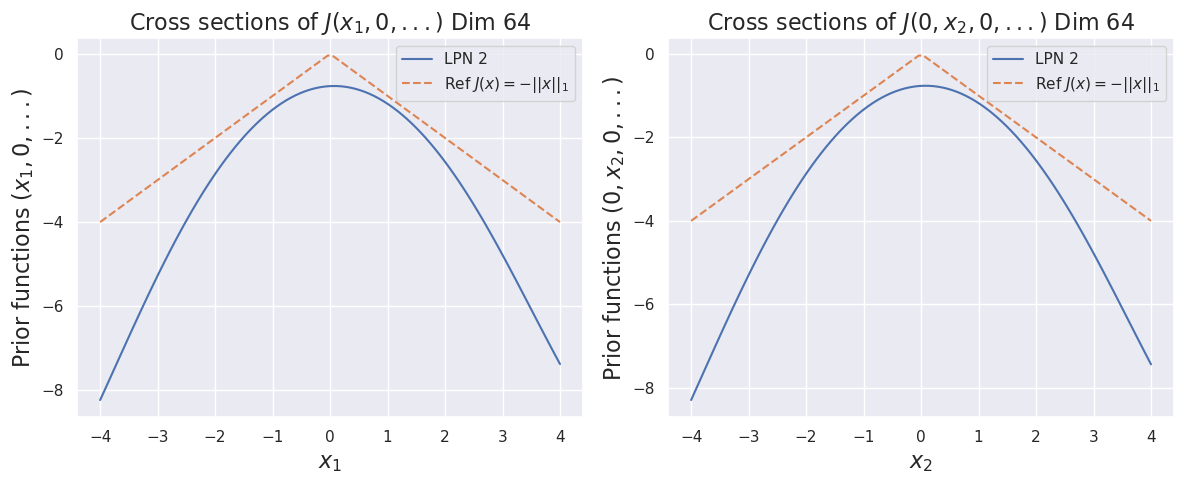

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Prior functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)